# Diffusion Model

The implemetatio of basic diffusio model is relatively easy. 
There are 2 basic compoets:
 - backboe model for noise prediction
 - scheduler to corrupt the original image according to a probalistic process.

The forward process consists of adding noises to image successively and the backward process estimates the noises and potentially to regain original image. 

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


## Vanilla Implementaion from scratch

We use MNIST dataset for simplicity. For more detailed implementation and explaination, refer to : https://github.com/niuniulla/MyPlayGround_DNNModels/blob/main/Diffusion_Model_from_scratch.ipynb.

### 1. Data

In [2]:
# load dataset

import torchvision.datasets as datasets
import torchvision.transforms as transforms

data_transforms = [
    transforms.ToTensor(), # convert to the range [0,1]
    transforms.Lambda(lambda x: x * 2 - 1) # convert to the range [-1,1]
]
data_transforms = transforms.Compose(data_transforms)

data = datasets.MNIST("./mnist", download=True, transform=data_transforms)

data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [80]:
# dataloader

import torch.utils.data as utils

batch_size = 256

train_loader = utils.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

print("there are :", len(train_loader), "batches")

there are : 235 batches


In [4]:
img0 = next(iter(train_loader))[0]
img0.shape

torch.Size([256, 1, 28, 28])

### 2. Define scheduler

In [88]:
# linear scheduling

def add_noise(img, level_noise) :
    noise = torch.rand_like(img)
    level_noise = level_noise.view(-1, 1, 1, 1)
    return img * (1 - level_noise) + noise * level_noise, noise

In [7]:
def add_noise(img, t:torch.Tensor, steps=40) :
    noise = torch.randn_like(img)
    level_noise = t.view(-1, 1, 1, 1) / steps
    return img * (1 - level_noise) + noise * level_noise, noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image size:  torch.Size([1, 28, 28])
tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])


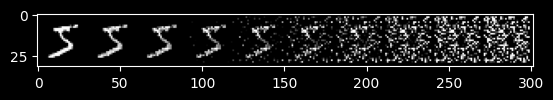

In [13]:
# forward process

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# to illustrate the effect of forward pass - noise adding process

num = 10
img0 = next(iter(train_loader))[0][0]
print("The image size: ", img0.shape)

noise_levels = torch.linspace(0, 1, num)
print(noise_levels)
img_noisy,_  = add_noise(img0, noise_levels)
plt.imshow(make_grid(img_noisy, nrow=num).permute(1,2,0))


# num = 10
# img0 = next(iter(train_loader))[0][0]
# print("The image size: ", img0.shape)

# ts = torch.tensor(range(0, 10))
# img_noisy, _ = add_noise(img0, ts, 10)
# plt.imshow(make_grid(img_noisy, nrow=num).permute(1,2,0))


### 3. model

In [89]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

In [15]:
x = torch.ones((64, 1, 28, 28))
y = model(x, 0)['sample']
y.size()

torch.Size([64, 1, 28, 28])

In [16]:
sum([l.numel() for l in model.parameters()])

1707009

### 4. sampling

To denoise the noisy image and get the original image, we need to reverse the forward process, which is called sampling.

In [64]:
#sampler

def sampling(num_steps, num_sample):
    x = torch.rand(num_sample, 1, 28, 28).to(model.device)
    for t in range (0, num_steps):
        with torch.no_grad():
            pred = model(x,0).sample 
        f = 1. / (num_steps - t)
        x = x * (1 - f) + pred * f
    return x

### 5. training 

In [90]:
epochs = 3

loss_fn = torch.nn.MSELoss()

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)

model.train()

losses = []

for e in range(epochs):

    for batch_img, batch_label in train_loader:

        # get noisy imgs
        xs = batch_img.to(device)
        noise_levels = torch.rand(xs.size()[0]).to(device)
        noisy_xs, noises = add_noise(xs, noise_levels)

        # prediction
        pred = model(noisy_xs, 0).sample

        # loss
        loss = loss_fn(pred, xs)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.cpu().item())

    epoch_loss = sum(losses[-len(train_loader):]) / len(train_loader)
    print(f'Epoch {e+1} / {epochs} - loss: {epoch_loss}')


Epoch 1 / 3 - loss: 0.07033454788492081
Epoch 2 / 3 - loss: 0.036145594525844496
Epoch 3 / 3 - loss: 0.03179752718102425


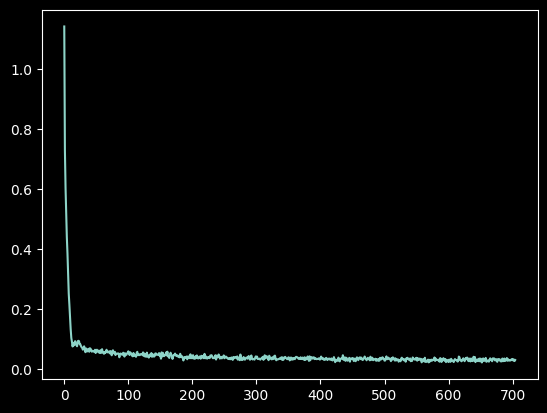

In [92]:
plt.plot(losses)

### 6. Inference

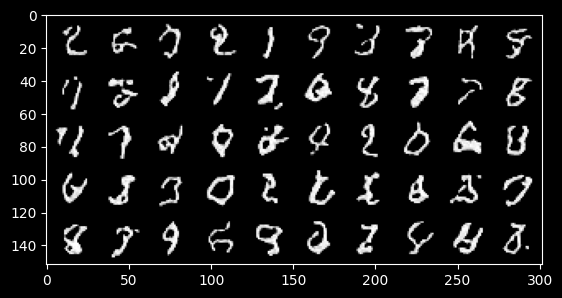

In [91]:
samples = sampling(20, 50).detach().cpu().clip(0, 1)
plt.imshow(make_grid(samples, nrow=10).permute(1,2,0))